# Result Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import PIL
from PIL import Image, ImageDraw
import os
%matplotlib inline

### Methods

In [2]:
def draw_keypoints_on_image(im, kpts, r=5, color=(255, 255, 255, 255), 
                            alpha=255, image_size=(84, 84)):
    im = (im.copy() * alpha).astype(np.uint8)
    scaled_kpts = kpts.copy()
    scaled_kpts = (scaled_kpts+1.0)*0.5*np.array(list(image_size))[None, :]
    scaled_kpts = scaled_kpts.astype(np.int)
    temp = scaled_kpts.copy()
    if not isinstance(im, Image.Image):
        im = Image.fromarray(im)

    im = im.resize(image_size, PIL.Image.BILINEAR)

    draw = ImageDraw.Draw(im)
    for i in range(len(scaled_kpts)):
        y, x = scaled_kpts[i].astype(np.int32)
        draw.ellipse([x - r, y - r, x + r, y + r], outline=color)
    return np.array(im), temp


def load_kpts(logs_path, batch_num, pkey_load=True, tp_load=True):
    gt, pkey_kpts, pkey_g_mask, pkey_e_mask = None, None, None, None
    if pkey_load:
        # load logs of pkey model
        pkey_f_name = 'batch_' + str(batch_num) + '_preds_masks.npz'
        # load logs of pkey_model
        pkey_data = np.load(logs_path + pkey_f_name)
        gt = pkey_data['arr_1']
        pkey_kpts = pkey_data['arr_2']
        pkey_g_mask = pkey_data['arr_3']
        pkey_g_mask = np.sum(pkey_g_mask, axis=3, keepdims=True)
        pkey_e_mask = pkey_data['arr_4']
    # load logs of tp_model
    tp_kpts, tp_preds = None, None
    if tp_load:
        tp_f_name = 'batch_' + str(batch_num) + '_keypoints.npz'
        tp_data = np.load(logs_path + tp_f_name)
        if logs_path.endswith("518085/") or logs_path.endswith("215831/"):  # error handling fix
            tp_kpts = tp_data['arr_0']
        else:
            tp_kpts = tp_data['arr_2']
        tp_preds = tp_data['arr_0']
    return gt, pkey_kpts, pkey_g_mask, pkey_e_mask, tp_kpts, tp_preds


def transporter_plot(rows_cols, fig_size, gt_img_pairs, kpts, preds, batch,
                    logs_base_dir, save=False):
    fig = plt.figure(figsize=fig_size)
    rows, columns = rows_cols[0], rows_cols[1]

    for i in range(1, columns + 1):
        # creating sub-plot axes
        ax1 = fig.add_subplot(rows, columns, i)
        ax1.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax2 = fig.add_subplot(rows, columns, i+columns)
        ax2.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax3 = fig.add_subplot(rows, columns, i+2*columns)
        ax3.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        
        if i % (columns + 1) == 1:
            ax1.set_ylabel('Image')
            ax2.set_ylabel('Reconstruction')
            ax3.set_ylabel('Transporter Keypoints')
        
        img_b = gt_img_pairs[(i+1)*4, :, :, :, 1]
        ax1.imshow(img_b)
        pred_img_b = preds[(i+1)*4, :, :, :]
        ax2.imshow(pred_img_b)
        keypoint_frame, temp = draw_keypoints_on_image(gt_img_pairs[(i+1)*4, :, :, :, 1], kpts[(i+1)*4, :, :], r=1)
        ax3.imshow(keypoint_frame)

    plt.tight_layout(pad=0.45, h_pad=0.4, w_pad=0.2)
    plt.show()
    if save:
        plt.savefig(logs_base_dir + "tp_plot_" + str(batch) + ".pdf", dpi=300)


def pkey_plot(rows_cols, fig_size, gt, kpts, e_mask, batch_num, save_dir, save=False):
    fig = plt.figure(figsize=fig_size)
    rows, columns = rows_cols[0], rows_cols[1]

    for i in range(1, columns+1):
        ax1 = fig.add_subplot(rows, columns, i)
        ax1.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax2 = fig.add_subplot(rows, columns, i+columns)
        ax2.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax3 = fig.add_subplot(rows, columns, i+2*columns)
        ax3.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax4 = fig.add_subplot(rows, columns, i+3*columns)
        ax4.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)

        if i % (columns + 1) == 1:
            ax1.set_ylabel('Image')
            ax2.set_ylabel('Keypoints (ours)')
            ax3.set_ylabel('Layer-0 Error Mask')
            ax4.set_ylabel('Layer-1 Error Mask')

        gt_img = gt[(i+1)*3, :, :, :]
        ax1.imshow(gt_img)
        kpt_frame, temp = draw_keypoints_on_image(gt[(i+1)*3, :, :, :], kpts[(i+1)*3, :, :], r=1)
        ax2.imshow(kpt_frame)
        ax3.imshow(e_mask[(i+1)*3, :, :, 0], cmap='gray')
        ax4.imshow(e_mask[(i+1)*3, :, :, 1], cmap='gray')

    plt.tight_layout(pad=0.2, w_pad=0.4, h_pad=0.4)
    plt.show()
    if save:
        plt.savefig(save_dir + "pkey_plot_" + str(batch_num) + ".pdf", dpi=300)


def compare_kpts_plot(env_names, rows_cols, fig_size, row_titles, gt, e_mask,
    kpts, batch_num, save_dir, tp_kpts=None, layer_ablation=False,
    nkpts_ablation=False, kp_regions=False, save=False):

    fig = plt.figure(figsize=fig_size)
    rows, columns = rows_cols[0], rows_cols[1]
    ax1, ax2, ax3, ax4, ax5 = None, None, None, None, None
    for i in range(1, columns+1):
        # creating sub-plots axes
        ax1 = fig.add_subplot(rows, columns, i)
        ax1.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax2 = fig.add_subplot(rows, columns, i+columns)
        ax2.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax3 = fig.add_subplot(rows, columns, i+2*columns)
        ax3.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax4 = fig.add_subplot(rows, columns, i+3*columns)
        ax4.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        if not nkpts_ablation:
            ax5 = fig.add_subplot(rows, columns, i+4*columns)
            ax5.tick_params(axis='both', which='both', bottom=False, top=False,
                            left=False, right=False, labelbottom=False,
                            labelleft=False)
        if not layer_ablation and not nkpts_ablation:
            # printing out column titles
            ax1.text(x=0.5, y=1.01, s=str(env_names[i-1]).capitalize(),
            horizontalalignment='center', fontsize=15, transform=ax1.transAxes)

        # printing out the row titles
        if i % (columns+1) == 1:
            ax1.set_ylabel(row_titles[0], fontsize=15)
            ax2.set_ylabel(row_titles[1], fontsize=15)
            ax3.set_ylabel(row_titles[2], fontsize=15)
            ax4.set_ylabel(row_titles[3], fontsize=15)
            if not nkpts_ablation:
                ax5.set_ylabel(row_titles[4], fontsize=15)

        # row-1 sub-plots
        gt_img = gt[i-1][(i+1)*3, :, :, :]
        ax1.imshow(gt_img)

        if not layer_ablation and not nkpts_ablation:
            # row-2 sub-plots
            tp_keypoint_frame, temp = draw_keypoints_on_image(gt_img, tp_kpts[i-1][batch_num[i-1], :, :], r=1)
            ax2.imshow(tp_keypoint_frame)
            # row-3 sub-plots
            pkey_keypoint_frame, temp = draw_keypoints_on_image(gt_img, kpts[i-1][batch_num[i-1], :, :], r=1)
            ax3.imshow(pkey_keypoint_frame)
            # row-4 sub-plots
            ax4.imshow(e_mask[i-1][batch_num[i-1], :, :, 0], cmap='gray')
            # row-5 sub-plots
            ax5.imshow(e_mask[i-1][batch_num[i-1], :, :, 1], cmap='gray')

        elif kp_regions:
            mask = resize(e_mask[i-1][batch_num[i-1], :, :, :], (84, 84), order=1)
            masked_img = mask[:, :, None]*gt_img
            ax3.imshow(masked_img)

        else:
            # row-2 sub-plots
            pkey_0_frame, temp = draw_keypoints_on_image(gt_img, kpts[0][(i+1)*3, :, :], r=1)
            ax2.imshow(pkey_0_frame)
            # row-3 sub-plots
            pkey_1_frame, temp = draw_keypoints_on_image(gt_img, kpts[1][(i+1)*3, :, :], r=1)
            ax3.imshow(pkey_1_frame)
            # row-4 sub-plots
            pkey_2_frame, temp = draw_keypoints_on_image(gt_img, kpts[2][(i+1)*3, :, :], r=1)
            ax4.imshow(pkey_2_frame)
            if not nkpts_ablation:
                # row-5 sub-plots
                pkey_3_frame, temp = draw_keypoints_on_image(gt_img, kpts[3][(i+1)*3, :, :], r=1)
                ax5.imshow(pkey_3_frame)

    plt.tight_layout(pad=0.45, h_pad=0.4, w_pad=0.2)
    plt.show()
    if save:  # save figs
        plt.savefig(save_dir + "compare_kpts_plot_" + str(batch_num[1]) + ".pdf", dpi=300)

        
def overlay_kpts_plot(rows_cols, fig_size, kpts_list, colors, gt, batch_num,
                    save_dir, save=False):

    fig = plt.figure(figsize=fig_size)
    rows, columns = rows_cols[0], rows_cols[1]

    for i in range(1, columns + 1):
        ax1 = fig.add_subplot(rows, columns, i)
        ax1.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)
        ax2 = fig.add_subplot(rows, columns, i+columns)
        ax2.tick_params(axis='both', which='both', bottom=False, top=False,
                        left=False, right=False, labelbottom=False,
                        labelleft=False)

        if i % (columns + 1) == 1:
            ax1.set_ylabel('Image')
            ax2.set_ylabel('Keypoints (ours)')

        # row-1 subplots
        gt_img = gt[(i+1)*3, :, :, :]
        ax1.imshow(gt_img)

        # row-2 subplots
        pkey_kpt_frame = gt_img
        for j in range(len(kpts_list)):
            pkey_kpt_frame, temp = draw_keypoints_on_image(pkey_kpt_frame, kpts_list[j][(i+1)*3, :, :], r=1, color=colors[j])
        ax2.imshow(pkey_kpt_frame)

    plt.tight_layout(pad=0.2, w_pad=0.4, h_pad=0.4)
    plt.show()
    if save:
        plt.savefig(save_dir + "overlay_kpt_plt_" + str(batch_num) + ".pdf", dpi=300)


### Basic Transporter viz

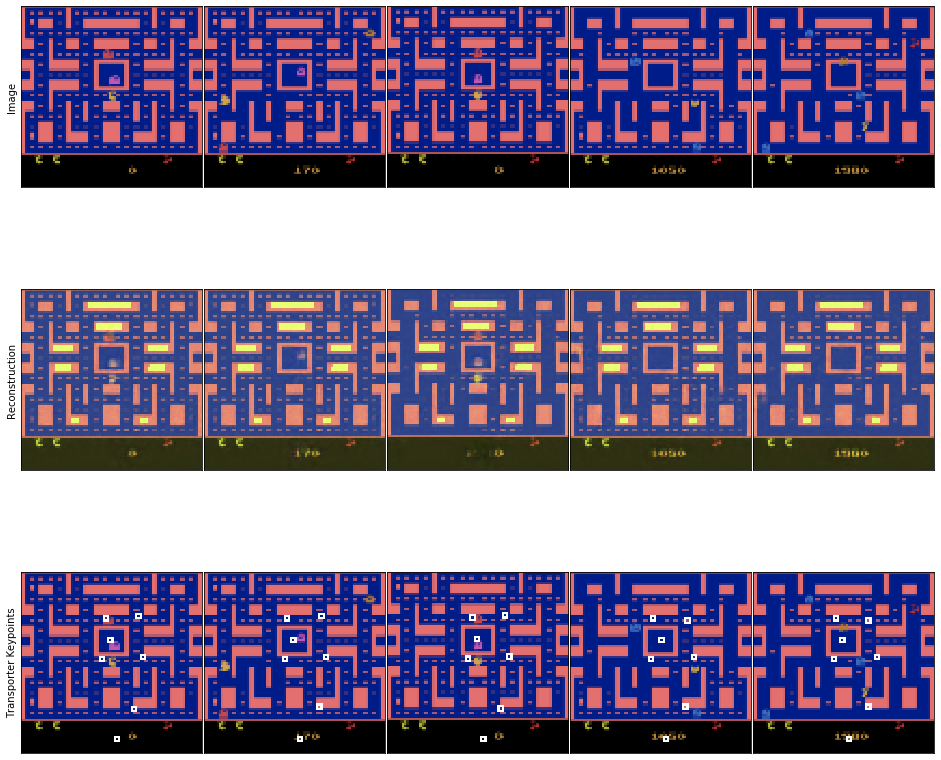

In [4]:
img_input = "dm_atari"
noise_type = "none"
env = "mspacman"
n_kpts = 7
logs_base_dir = "transporter_exp/" + img_input + "/" + noise_type + \
"/" + env + "/" + str(n_kpts) + "/" + "2021-03-18T12:56:46.725926/test_logs/"

ckpt_epoch = 0
batch = 30
f_name = 'epoch_' + str(ckpt_epoch) + '_batch_' + str(batch) + '_keypoints.npz'
tp_data = np.load(logs_base_dir + f_name)

preds = tp_data['arr_0']
gt_img_pairs = tp_data['arr_1']
kpts = tp_data['arr_2']
masks = tp_data['arr_3']
fig_size = (13, 13)
rows_cols = [3, 5]
transporter_plot(rows_cols, fig_size, gt_img_pairs, kpts, preds, batch, logs_base_dir)

### Basic PermaKey viz

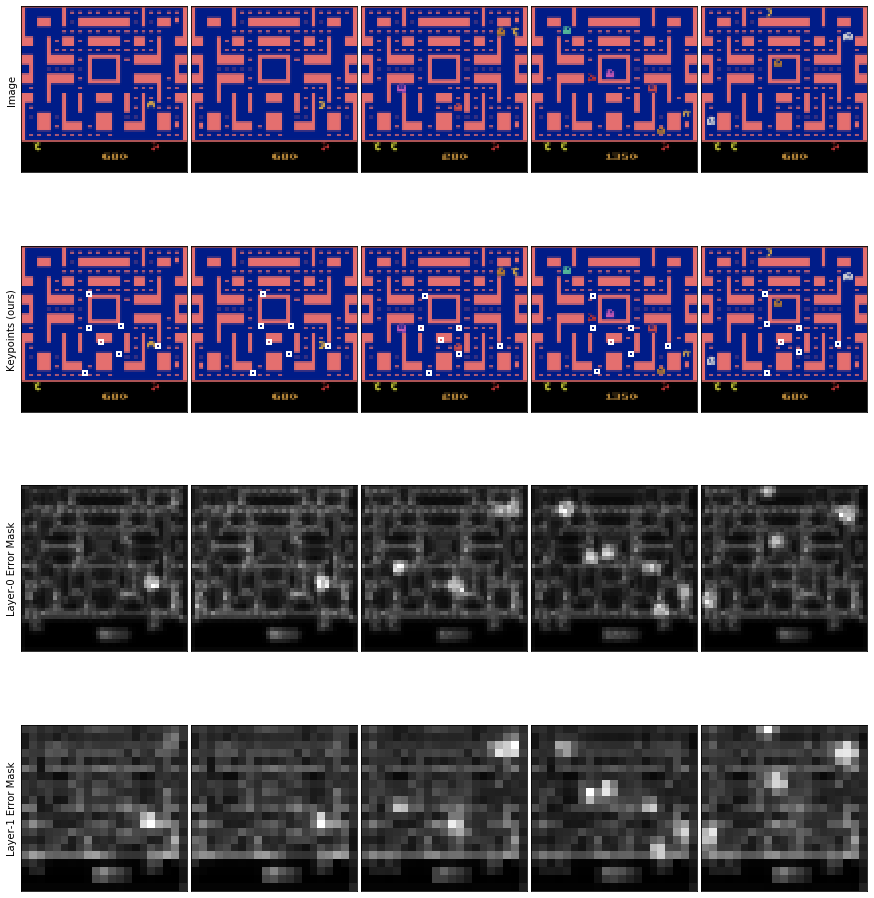

In [6]:
img_input = "dm_atari"
noise_type = "none"
env = "mspacman"
n_kpts = 7
logs_base_dir = "permakey_exp/" + img_input + "/" + noise_type + \
"/" + env + "/" + str(n_kpts) + "/" + "2021-03-19T12:06:33.102525/test_logs/"

ckpt_epoch = 1
batch = 15
f_name = 'epoch_' + str(ckpt_epoch) + '_batch_' + str(batch) + '_preds_masks.npz'
pkey_data = np.load(logs_base_dir + f_name)

preds = pkey_data['arr_0']
gt = pkey_data['arr_1']
kpts = pkey_data['arr_2']
masks = pkey_data['arr_3']
error_maps = pkey_data['arr_4']
fig_size = (12, 14)
rows_cols = [4, 5]
pkey_plot(rows_cols, fig_size, gt, kpts, error_maps, batch, logs_base_dir)

### Atari - compare keypoint plots

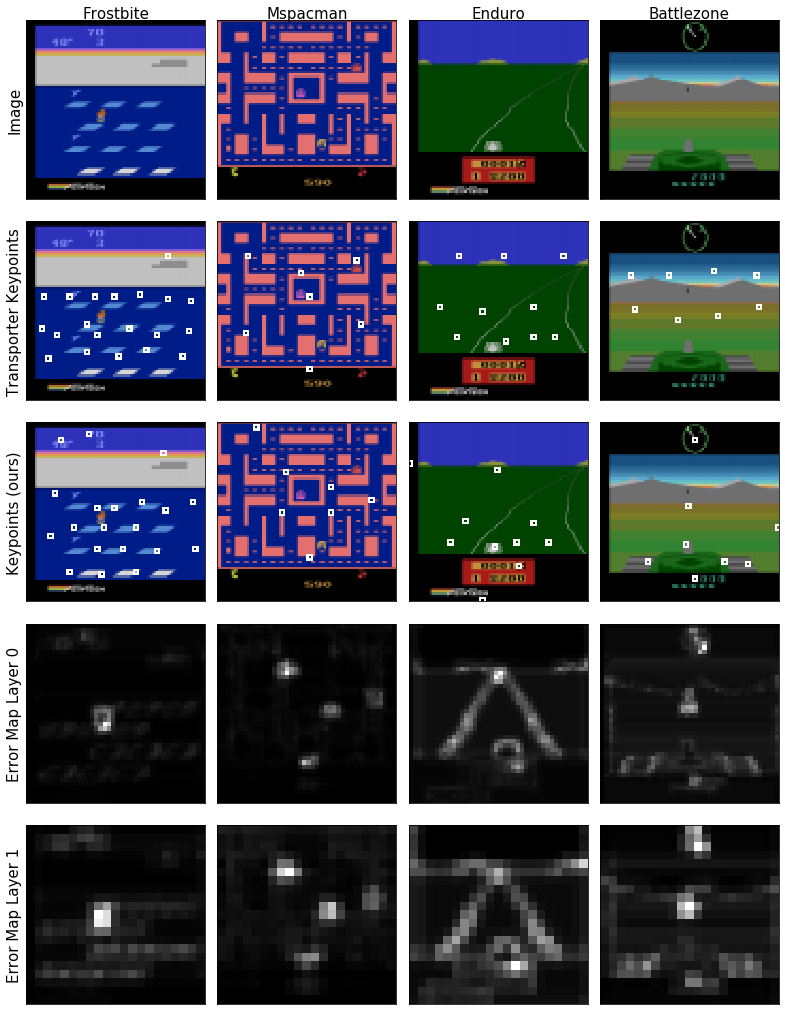

In [7]:
logs_base_dir = "../mutual_information_keypoints/compare_kpts/dm_atari/"
noise_type = "none"
rows_cols = [5, 4]
fig_size = (11, 14)
row_titles = ["Image", "Transporter Keypoints", "Keypoints (ours)", "Error Map Layer 0", "Error Map Layer 1"]
env_names = ["frostbite", "mspacman", "enduro", "battlezone"]
n_kpts = ["20", "7", "10", "8"]

fr_logs_path = logs_base_dir + noise_type + "/" + env_names[0] + "/" + n_kpts[0] + "/" + "018612_518648/"
fr_batch_num = 15
fr_gt, fr_kpts, fr_g_mask, fr_e_mask, fr_tp_kpts, _ = load_kpts(fr_logs_path, fr_batch_num)

pc_logs_path = logs_base_dir + noise_type + "/" + env_names[1] + "/" + n_kpts[1] + "/" + "816814_341747/"
pc_batch_num = 25
pc_gt, pc_kpts, pc_g_mask, pc_e_mask, pc_tp_kpts, _ = load_kpts(pc_logs_path, pc_batch_num)

end_logs_path = logs_base_dir + noise_type + "/" + env_names[2] + "/" + n_kpts[2] + "/" + "762551_920867/"
end_batch_num = 15
end_gt, end_kpts, end_g_mask, end_e_mask, end_tp_kpts, _ = load_kpts(end_logs_path, end_batch_num)

bat_logs_path = logs_base_dir + noise_type + "/" + env_names[3] + "/" + n_kpts[3] + "/" + "033354_518085/"
bat_batch_num = 10
bat_gt, bat_kpts, bat_g_mask, bat_e_mask, bat_tp_kpts, _ = load_kpts(bat_logs_path, bat_batch_num)

gt = [fr_gt, pc_gt, end_gt, bat_gt]
e_mask = [fr_e_mask, pc_e_mask, end_e_mask, bat_e_mask]
kpts = [fr_kpts, pc_kpts, end_kpts, bat_kpts]
tp_kpts = [fr_tp_kpts, pc_tp_kpts, end_tp_kpts, bat_tp_kpts]
batch_num = [fr_batch_num, pc_batch_num, end_batch_num, bat_batch_num]
compare_kpts_plot(env_names, rows_cols, fig_size, row_titles, gt, e_mask, kpts, batch_num, logs_base_dir, tp_kpts)

### Noisy Atari - compare keypoint plots

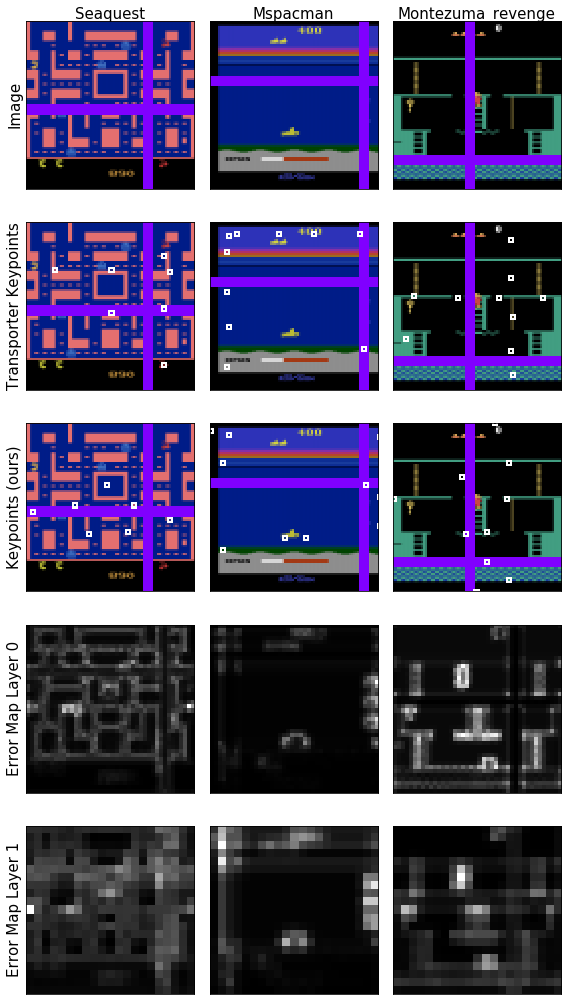

In [8]:
logs_base_dir = "../mutual_information_keypoints/compare_kpts/dm_atari/"
noise_type = "both"
rows_cols = [5, 3]
fig_size = (8, 14)
row_titles = ["Image", "Transporter Keypoints", "Keypoints (ours)", "Error Map Layer 0", "Error Map Layer 1"]
env_names = ["seaquest", "mspacman", "montezuma_revenge"]
n_kpts = ["10", "7", "10"]

sp_logs_path = logs_base_dir + noise_type + "/" + env_names[0] + "/" + n_kpts[0] + "/" + "123924_995788/"
sp_batch_num = 4
sp_gt, sp_kpts, sp_g_mask, sp_e_mask, sp_tp_kpts, _ = load_kpts(sp_logs_path, sp_batch_num)

pcmn_logs_path = logs_base_dir + noise_type + "/" + env_names[1] + "/" + n_kpts[1] + "/" + "825526_952019/"
pcmn_batch_num = 27
pcmn_gt, pcmn_kpts, pcmn_g_mask, pcmn_e_mask, pcmn_tp_kpts, _ = load_kpts(pcmn_logs_path, pcmn_batch_num)

mzr_logs_path = logs_base_dir + noise_type + "/" + env_names[2] + "/" + n_kpts[2] + "/" + "211744_215831/"
mzr_batch_num = 10
mzr_gt, mzr_kpts, mzr_g_mask, mzr_e_mask, mzr_tp_kpts, _ = load_kpts(mzr_logs_path, mzr_batch_num)

gt = [pcmn_gt, sp_gt, mzr_gt]
e_mask = [pcmn_e_mask, sp_e_mask, mzr_e_mask]
kpts = [pcmn_kpts, sp_kpts, mzr_kpts]
tp_kpts = [pcmn_tp_kpts, sp_tp_kpts, mzr_tp_kpts]
batch_num = [pcmn_batch_num, sp_batch_num, mzr_batch_num]
compare_kpts_plot(env_names, rows_cols, fig_size, row_titles, gt, e_mask, kpts, batch_num, logs_base_dir, tp_kpts)

### LSP layer ablation plots

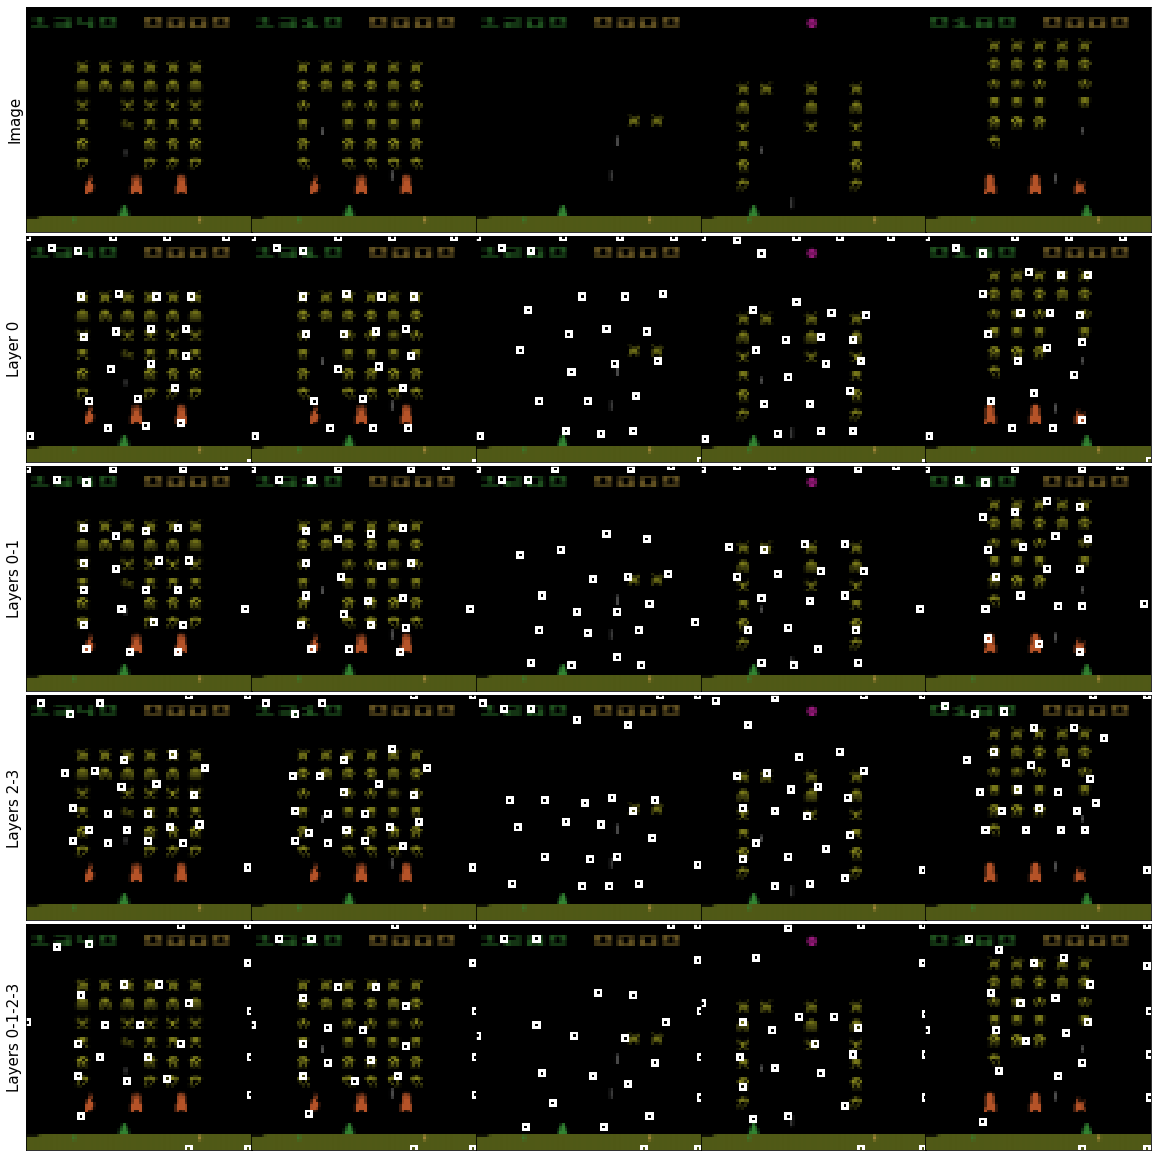

In [10]:
env_name = "space_invaders"
noise_type = "none"
logs_base_dir = "/media/anand/Volume/exp/compare_kpts/dm_atari/" + noise_type + "/" + env_name + "/" + "25/"
rows_cols = [5, 5]
fig_size = (16, 16)
row_titles = ["Image", "Layer 0", "Layers 0-1", "Layers 2-3", "Layers 0-1-2-3"]
# lsp layer-0 model
sp_0_compare_logs_path = logs_base_dir + "143210/"
sp_0_batch_num = 30
sp_0_gt, sp_0_kpts, sp_0_g_mask, sp_0_e_mask, _, _ = load_kpts(sp_0_compare_logs_path, sp_0_batch_num, tp_load=False)
# lsp layer-0-1 model
sp_01_compare_logs_path = logs_base_dir + "736432/"
sp_01_batch_num = 30
sp_01_gt, sp_01_kpts, sp_01_g_mask, sp_01_e_mask, _, _ = load_kpts(sp_01_compare_logs_path, sp_01_batch_num, tp_load=False)
# lsp layer-2-3 model
sp_23_compare_logs_path = logs_base_dir + "572251/"
sp_23_batch_num = 30
sp_23_gt, sp_23_kpts, sp_23_g_mask, sp_23_e_mask, _, _ = load_kpts(sp_23_compare_logs_path, sp_23_batch_num, tp_load=False)
# lsp layer-0-1-2-3 model
sp_0123_compare_logs_path = logs_base_dir + "879453/"
sp_0123_batch_num = 30
sp_0123_gt, sp_0123_kpts, sp_0123_g_mask, sp_0123_e_mask, _, _ = load_kpts(sp_0123_compare_logs_path, sp_0123_batch_num, tp_load=False)

gt = [sp_0_gt]*rows_cols[1]
e_mask = [sp_0_e_mask, sp_01_e_mask, sp_23_e_mask, sp_0123_e_mask]
kpts = [sp_0_kpts, sp_01_kpts, sp_23_kpts, sp_0123_kpts]
batch_num = [sp_0_batch_num, sp_01_batch_num, sp_23_batch_num, sp_0123_batch_num]
compare_kpts_plot(env_names, rows_cols, fig_size, row_titles, gt, e_mask, kpts, 
                  batch_num, logs_base_dir, layer_ablation=True)

### Number of keypoints ablation plots

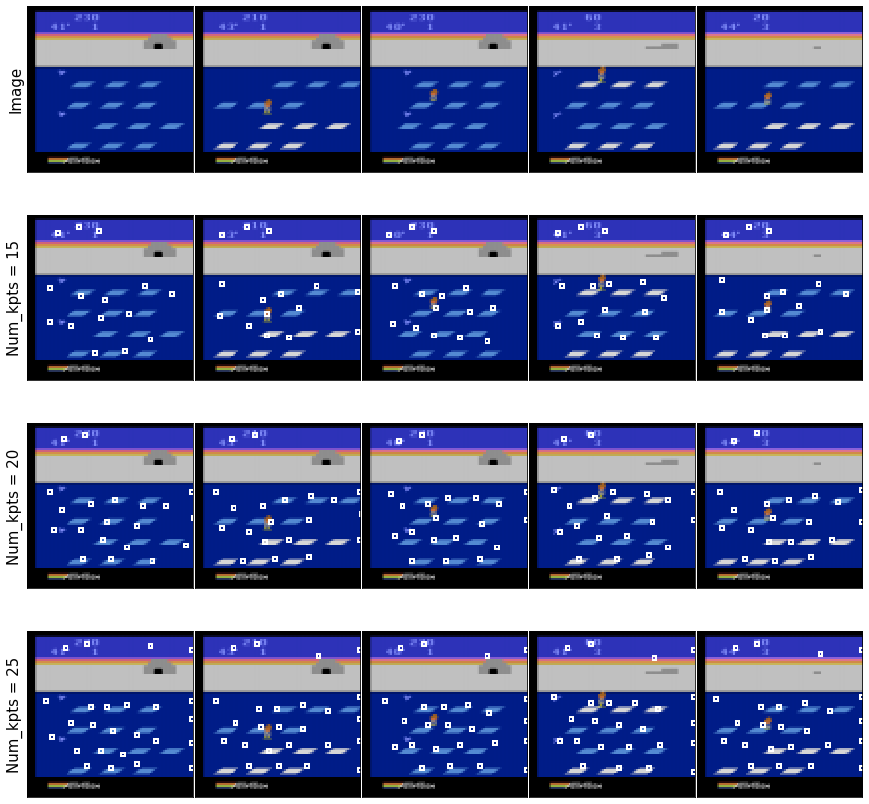

In [11]:
env_name = "frostbite"
noise_type = "none"
logs_base_dir = "/media/anand/Volume/exp/compare_kpts/dm_atari/" + noise_type + "/" + env_name + "/"
rows_cols = [4, 5]
fig_size = (12, 12)
row_titles = ["Image", "Num_kpts = 15", "Num_kpts = 20", "Num_kpts = 25"]

fr_15_compare_logs_path = logs_base_dir + "15/202050/"
fr_15_batch_num = 25
fr_15_gt, fr_15_kpts, fr_15_g_mask, fr_15_e_mask, _, _ = load_kpts(fr_15_compare_logs_path, fr_15_batch_num, tp_load=False)

fr_20_compare_logs_path = logs_base_dir + "20/417945/"
fr_20_batch_num = 25
fr_20_gt, fr_20_kpts, fr_20_g_mask, fr_20_e_mask, _, _ = load_kpts(fr_20_compare_logs_path, fr_20_batch_num, tp_load=False)

fr_25_compare_logs_path = logs_base_dir + "25/940738/"
fr_25_batch_num = 25
fr_25_gt, fr_25_kpts, fr_25_g_mask, fr_25_e_mask, _, _ = load_kpts(fr_25_compare_logs_path, fr_25_batch_num, tp_load=False)

gt = [fr_15_gt]*rows_cols[1]
e_mask = [fr_15_e_mask, fr_20_e_mask, fr_25_e_mask]
kpts = [fr_15_kpts, fr_20_kpts, fr_25_kpts]
batch_num = [fr_15_batch_num, fr_20_batch_num, fr_25_batch_num]
compare_kpts_plot(env_names, rows_cols, fig_size, row_titles, gt, e_mask, kpts, 
                  batch_num, logs_base_dir, nkpts_ablation=True)

### Seeds ablation plots

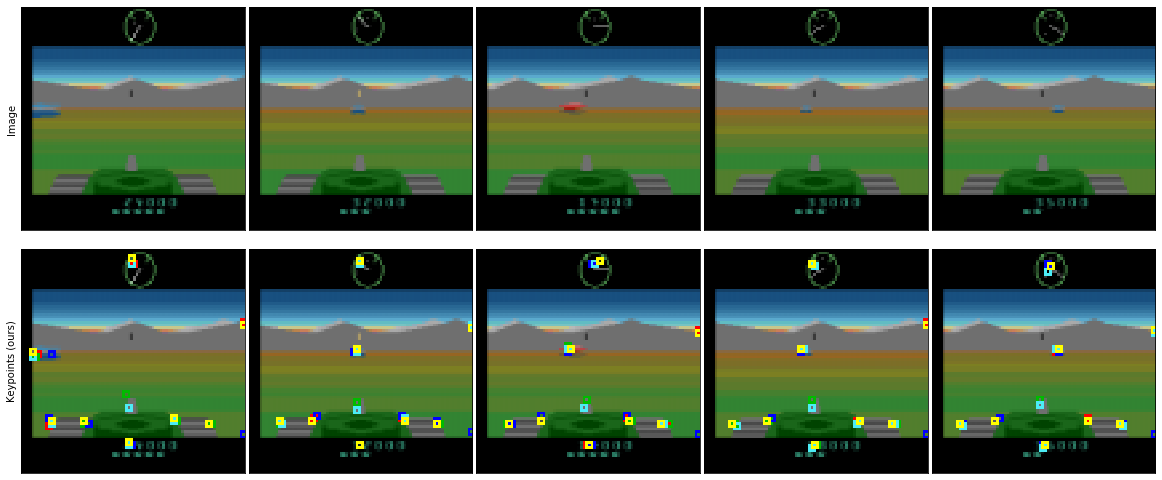

In [13]:
logs_base_dir = "../mutual_information_keypoints/compare_kpts/dm_atari/"
noise_type = "none"
env_names = "battlezone"
overlay_logs_path = logs_base_dir + noise_type + "/" + env_names + "/" + "8/"
rows_cols = [2, 5]
fig_size = (16, 7)
n_kpts = 8
batch_num = 43
# select unique ids (i.e. folder names) of seeds you want to plot
model_ids_list = ["152312/", "467951/", "717927/", "822005/", "966317/"]
colors = [(255, 0, 0, 128), (255, 70, 0, 128), (0, 0, 255, 128), (180, 20, 10, 128), (255, 255, 0, 128)]
kpts_list = []
for model_id in model_ids_list:
    logs_path = overlay_logs_path + model_id
    gt, kpts, g_mask, e_mask, _, _ = load_kpts(logs_path, batch_num, tp_load=False)
    kpts_list.append(kpts)
overlay_kpts_plot(rows_cols, fig_size, kpts_list, colors, gt, batch_num, logs_base_dir)